In [26]:
# Imports
import numpy as np
import pickle
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from skimage.metrics import structural_similarity as ssim

In [27]:
base = Path("/gpfs/commons/home/svaidyanathan/istarc")  # adjust if needed

heat_dir = base / "data" / "heat_diffused_data"

npy_path = heat_dir / "visium_mouse_brain_pixel_gene_maps.npy"
genes_txt_path = heat_dir / "visium_mouse_brain_pixel_gene_maps_genes.txt"

ge_pixel_maps = np.load(npy_path)
print("ge_pixel_maps shape:", ge_pixel_maps.shape)

with open(genes_txt_path) as f:
    genes_for_pixels = [line.strip() for line in f]

print("Genes in order:", genes_for_pixels)
gene_to_idx = {g: i for i, g in enumerate(genes_for_pixels)}


ge_pixel_maps shape: (912, 880, 2725)
Genes in order: ['0610030E20Rik', '0610040J01Rik', '1110017D15Rik', '1600002K03Rik', '1700001K19Rik', '1700006F04Rik', '1700019D03Rik', '1700023F06Rik', '1700025G04Rik', '1700030K09Rik', '1700066M21Rik', '2010300C02Rik', '2310040G24Rik', '2410004B18Rik', '2410131K14Rik', '2510009E07Rik', '2610001J05Rik', '2900026A02Rik', '3110021N24Rik', '3300002A11Rik', '4930480K15Rik', '4930506C21Rik', '4931428F04Rik', '5031439G07Rik', '5330417C22Rik', '6030443J06Rik', '6330403K07Rik', '6330409D20Rik', '6430548M08Rik', '9230102O04Rik', '9430038I01Rik', '9430091E24Rik', '9530082P21Rik', 'A230056P14Rik', 'A330074K22Rik', 'A430035B10Rik', 'A530058N18Rik', 'A930006K02Rik', 'A930009A15Rik', 'Aar2', 'Aars2', 'Aatf', 'Abca2', 'Abca3', 'Abca9', 'Abcb1a', 'Abcb7', 'Abcc8', 'Abcc9', 'Abcd2', 'Abcg2', 'Abcg4', 'Abhd2', 'Abhd4', 'Abi3', 'Abt1', 'Abtb2', 'Acaa1a', 'Acadl', 'Acp1', 'Acsl3', 'Acsl6', 'Acta2', 'Actn2', 'Acvr2a', 'Acvrl1', 'Adam11', 'Adam12', 'Adam17', 'Adam19', 

In [28]:
istar_dir = base / "istar" / "data" / "visium_mouse_brain_ct" / "cnts-super"

def load_istar_gene(gene):
    p = istar_dir / f"{gene}.pickle"
    with open(p, "rb") as f:
        arr = pickle.load(f)
    arr = np.asarray(arr)
    print(gene, arr.shape)
    return arr


In [29]:
def min_max_norm(x):
    x = x.astype(float)
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    rng = x_max - x_min
    if rng <= 0:
        return np.zeros_like(x)
    return (x - x_min) / rng

def metrics_on_confident_region(heat_map, istar_map, frac=0.3):
    """
    Compare only in the top `frac` fraction of heat_map pixels (where diffusion is strongest).
    """
    h_flat = heat_map.ravel()

    # focus only on non-zero pixels
    nz = h_flat[h_flat > 0]
    if nz.size == 0:
        return np.nan, np.nan

    # threshold = e.g. top 30% of nonzero heat diffusion values
    thr = np.quantile(nz, 1 - frac)
    mask = heat_map >= thr

    h_sel = heat_map[mask]
    i_sel = istar_map[mask]

    # Spearman on confident region
    rho, _ = spearmanr(h_sel, i_sel)

    # SSIM on masked region: zero out everything else
    h_norm = min_max_norm(heat_map)
    i_norm = min_max_norm(istar_map)
    h_masked = np.where(mask, h_norm, 0)
    i_masked = np.where(mask, i_norm, 0)
    ssim_val = ssim(h_masked, i_masked, data_range=1.0)

    return rho, ssim_val


In [31]:
for gene in genes_for_pixels:
    try:
        heat_map = ge_pixel_maps[:, :, gene_to_idx[gene]]
        istar_map = load_istar_gene(gene)
    except FileNotFoundError:
        print(f"{gene} – skipped (iSTAR pickle not found)")
        continue

    rho_conf, ssim_conf = metrics_on_confident_region(
        heat_map, istar_map, frac=0.3
    )

    print(f"{gene} – confident-region Spearman ρ = {rho_conf:.3f}, SSIM = {ssim_conf:.3f}")


0610030E20Rik – skipped (iSTAR pickle not found)
0610040J01Rik – skipped (iSTAR pickle not found)
1110017D15Rik – skipped (iSTAR pickle not found)
1600002K03Rik – skipped (iSTAR pickle not found)
1700001K19Rik – skipped (iSTAR pickle not found)
1700006F04Rik – skipped (iSTAR pickle not found)
1700019D03Rik – skipped (iSTAR pickle not found)
1700023F06Rik – skipped (iSTAR pickle not found)
1700025G04Rik – skipped (iSTAR pickle not found)
1700030K09Rik – skipped (iSTAR pickle not found)
1700066M21Rik – skipped (iSTAR pickle not found)
2010300C02Rik (912, 880)


2010300C02Rik – confident-region Spearman ρ = 0.329, SSIM = 0.931
2310040G24Rik – skipped (iSTAR pickle not found)
2410004B18Rik – skipped (iSTAR pickle not found)
2410131K14Rik – skipped (iSTAR pickle not found)
2510009E07Rik – skipped (iSTAR pickle not found)
2610001J05Rik – skipped (iSTAR pickle not found)
2900026A02Rik – skipped (iSTAR pickle not found)
3110021N24Rik – skipped (iSTAR pickle not found)
3300002A11Rik – skipped (iSTAR pickle not found)
4930480K15Rik – skipped (iSTAR pickle not found)
4930506C21Rik – skipped (iSTAR pickle not found)
4931428F04Rik – skipped (iSTAR pickle not found)
5031439G07Rik (912, 880)
5031439G07Rik – confident-region Spearman ρ = 0.360, SSIM = 0.913
5330417C22Rik – skipped (iSTAR pickle not found)
6030443J06Rik – skipped (iSTAR pickle not found)
6330403K07Rik (912, 880)
6330403K07Rik – confident-region Spearman ρ = 0.598, SSIM = 0.929
6330409D20Rik – skipped (iSTAR pickle not found)
6430548M08Rik (912, 880)
6430548M08Rik – confident-region Spearman

In [32]:
def topk_overlap(heat_map, istar_map, k=0.05):
    """
    Jaccard/Dice overlap of top-k% high-expression pixels.
    """
    h_flat = heat_map.ravel()
    i_flat = istar_map.ravel()

    # thresholds at top k% for each method
    h_thr = np.quantile(h_flat, 1 - k)
    i_thr = np.quantile(i_flat, 1 - k)

    h_top = heat_map >= h_thr
    i_top = istar_map >= i_thr

    inter = np.logical_and(h_top, i_top).sum()
    union = np.logical_or(h_top, i_top).sum()
    jaccard = inter / union if union > 0 else np.nan
    dice = 2 * inter / (h_top.sum() + i_top.sum()) if (h_top.sum() + i_top.sum()) > 0 else np.nan

    return jaccard, dice


In [34]:
for gene in genes_for_pixels:
    try:
        heat_map = ge_pixel_maps[:, :, gene_to_idx[gene]]
        istar_map = load_istar_gene(gene)
    except FileNotFoundError:
        print(f"{gene} – skipped (iSTAR pickle not found)")
        continue

    jacc, dice = topk_overlap(heat_map, istar_map, k=0.05)

    print(f"{gene} – Top-5% overlap: Jaccard = {jacc:.3f}, Dice = {dice:.3f}")


0610030E20Rik – skipped (iSTAR pickle not found)
0610040J01Rik – skipped (iSTAR pickle not found)
1110017D15Rik – skipped (iSTAR pickle not found)
1600002K03Rik – skipped (iSTAR pickle not found)
1700001K19Rik – skipped (iSTAR pickle not found)
1700006F04Rik – skipped (iSTAR pickle not found)
1700019D03Rik – skipped (iSTAR pickle not found)
1700023F06Rik – skipped (iSTAR pickle not found)
1700025G04Rik – skipped (iSTAR pickle not found)
1700030K09Rik – skipped (iSTAR pickle not found)
1700066M21Rik – skipped (iSTAR pickle not found)
2010300C02Rik (912, 880)
2010300C02Rik – Top-5% overlap: Jaccard = 0.351, Dice = 0.519
2310040G24Rik – skipped (iSTAR pickle not found)
2410004B18Rik – skipped (iSTAR pickle not found)
2410131K14Rik – skipped (iSTAR pickle not found)
2510009E07Rik – skipped (iSTAR pickle not found)
2610001J05Rik – skipped (iSTAR pickle not found)
2900026A02Rik – skipped (iSTAR pickle not found)
3110021N24Rik – skipped (iSTAR pickle not found)
3300002A11Rik – skipped (iSTAR 

6330403K07Rik (912, 880)
6330403K07Rik – Top-5% overlap: Jaccard = 0.515, Dice = 0.680
6330409D20Rik – skipped (iSTAR pickle not found)
6430548M08Rik (912, 880)
6430548M08Rik – Top-5% overlap: Jaccard = 0.249, Dice = 0.399
9230102O04Rik – skipped (iSTAR pickle not found)
9430038I01Rik – skipped (iSTAR pickle not found)
9430091E24Rik – skipped (iSTAR pickle not found)
9530082P21Rik – skipped (iSTAR pickle not found)
A230056P14Rik – skipped (iSTAR pickle not found)
A330074K22Rik – skipped (iSTAR pickle not found)
A430035B10Rik – skipped (iSTAR pickle not found)
A530058N18Rik – skipped (iSTAR pickle not found)
A930006K02Rik – skipped (iSTAR pickle not found)
A930009A15Rik – skipped (iSTAR pickle not found)
Aar2 – skipped (iSTAR pickle not found)
Aars2 – skipped (iSTAR pickle not found)
Aatf – skipped (iSTAR pickle not found)
Abca2 (912, 880)
Abca2 – Top-5% overlap: Jaccard = 0.362, Dice = 0.532
Abca3 – skipped (iSTAR pickle not found)
Abca9 – skipped (iSTAR pickle not found)
Abcb1a – skip

Apoo (912, 880)
Agap2 (912, 880)


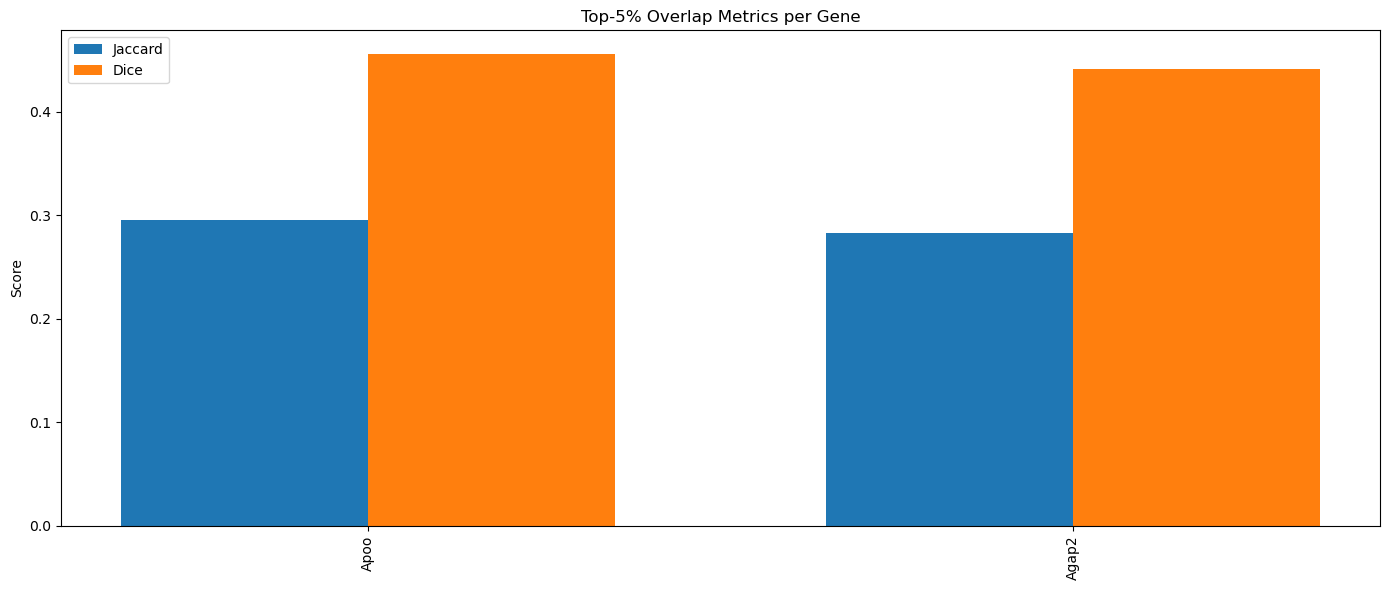

In [25]:
genes = []
jaccards = []
dices = []      # list
                # ↓ float from topk_overlap
for gene in genes_for_pixels:
    heat_map = ge_pixel_maps[:, :, gene_to_idx[gene]]
    istar_map = load_istar_gene(gene)

    jacc, dice_val = topk_overlap(heat_map, istar_map, k=0.05)

    genes.append(gene)
    jaccards.append(jacc)
    dices.append(dice_val)   # correct list and correct variable name

# Convert to arrays
x = np.arange(len(genes))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x - width/2, jaccards, width, label="Jaccard")
ax.bar(x + width/2, dices, width, label="Dice")

ax.set_ylabel("Score")
ax.set_title("Top-5% Overlap Metrics per Gene")
ax.set_xticks(x)
ax.set_xticklabels(genes, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt

def plot_with_contours(gene):
    idx = gene_to_idx[gene]
    heat_map = ge_pixel_maps[:, :, idx]
    istar_map = load_istar_gene(gene)

    # mask = top 30% of heat diffusion
    nz = heat_map[heat_map > 0]
    thr = np.quantile(nz, 0.7) if nz.size > 0 else np.inf
    mask = heat_map >= thr

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    im0 = ax[0].imshow(heat_map)
    ax[0].set_title(f"{gene} – Heat diffusion")
    ax[0].axis("off")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(istar_map)
    ax[1].set_title(f"{gene} – iSTAR")
    ax[1].axis("off")
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(istar_map)
    ax[2].contour(mask, colors="red", linewidths=1)  # show where heat diffusion is strongest
    ax[2].set_title(f"{gene} – iSTAR with heat high-region (red)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

0610030E20Rik – skipped (iSTAR pickle not found)
0610040J01Rik – skipped (iSTAR pickle not found)
1110017D15Rik – skipped (iSTAR pickle not found)
1600002K03Rik – skipped (iSTAR pickle not found)
1700001K19Rik – skipped (iSTAR pickle not found)
1700006F04Rik – skipped (iSTAR pickle not found)
1700019D03Rik – skipped (iSTAR pickle not found)
1700023F06Rik – skipped (iSTAR pickle not found)
1700025G04Rik – skipped (iSTAR pickle not found)
1700030K09Rik – skipped (iSTAR pickle not found)
1700066M21Rik – skipped (iSTAR pickle not found)
2010300C02Rik (912, 880)
2010300C02Rik (912, 880)


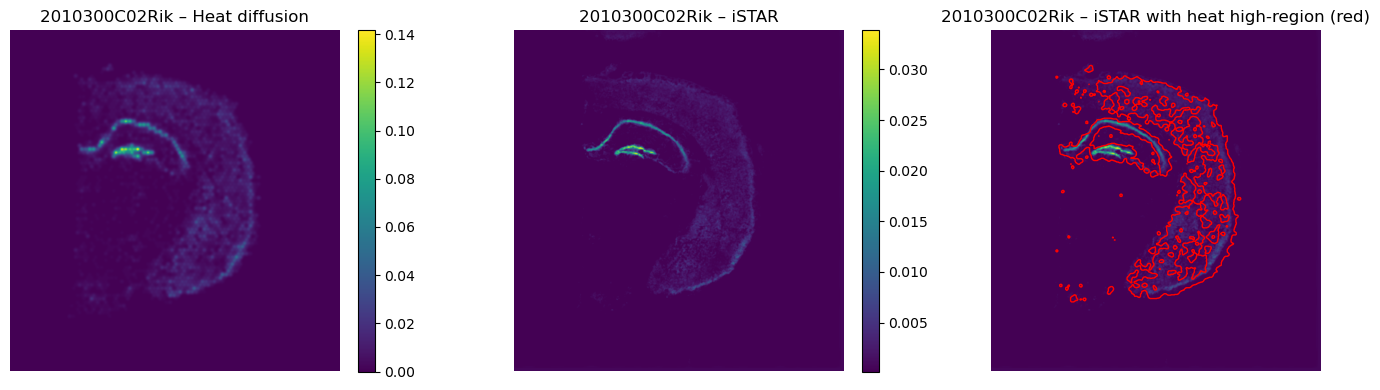

2310040G24Rik – skipped (iSTAR pickle not found)
2410004B18Rik – skipped (iSTAR pickle not found)
2410131K14Rik – skipped (iSTAR pickle not found)
2510009E07Rik – skipped (iSTAR pickle not found)
2610001J05Rik – skipped (iSTAR pickle not found)
2900026A02Rik – skipped (iSTAR pickle not found)
3110021N24Rik – skipped (iSTAR pickle not found)
3300002A11Rik – skipped (iSTAR pickle not found)
4930480K15Rik – skipped (iSTAR pickle not found)
4930506C21Rik – skipped (iSTAR pickle not found)
4931428F04Rik – skipped (iSTAR pickle not found)
5031439G07Rik (912, 880)
5031439G07Rik (912, 880)


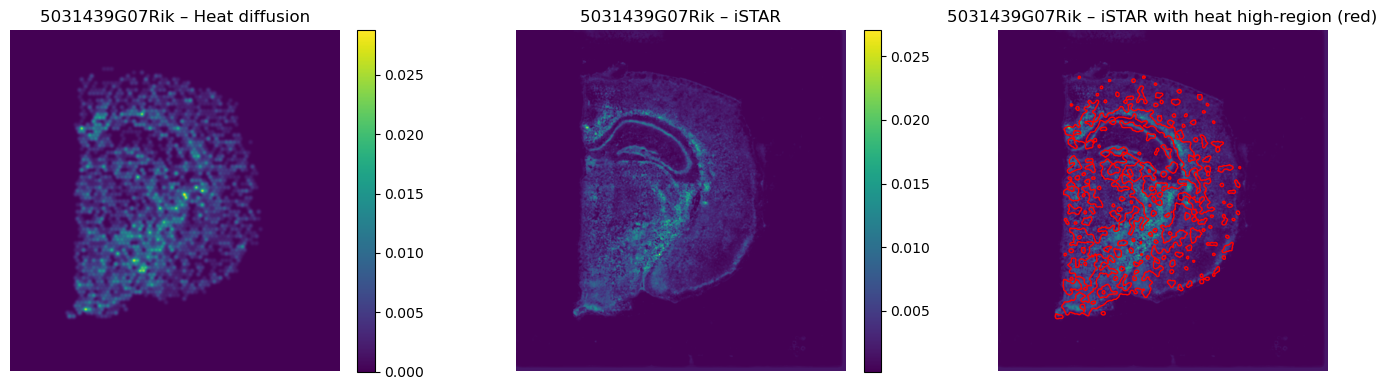

5330417C22Rik – skipped (iSTAR pickle not found)
6030443J06Rik – skipped (iSTAR pickle not found)
6330403K07Rik (912, 880)
6330403K07Rik (912, 880)


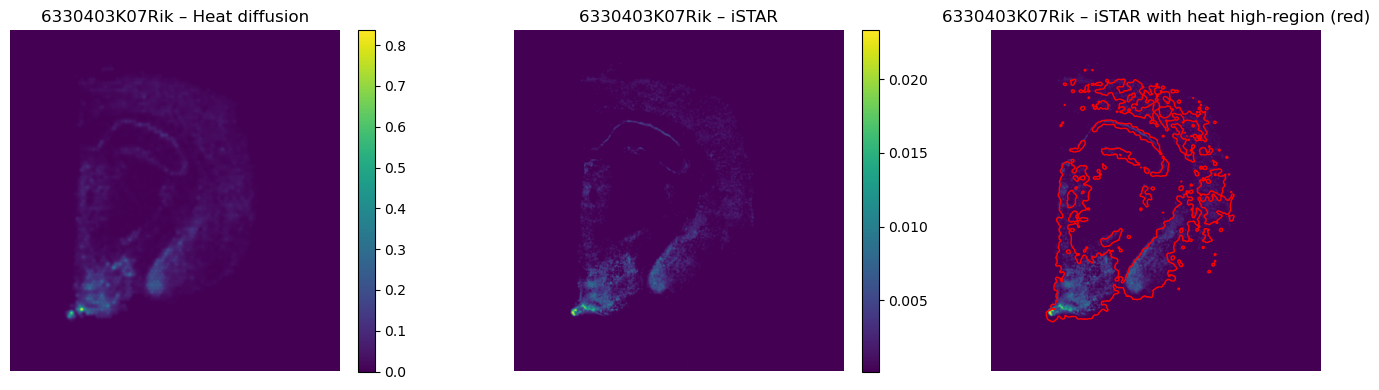

6330409D20Rik – skipped (iSTAR pickle not found)
6430548M08Rik (912, 880)
6430548M08Rik (912, 880)


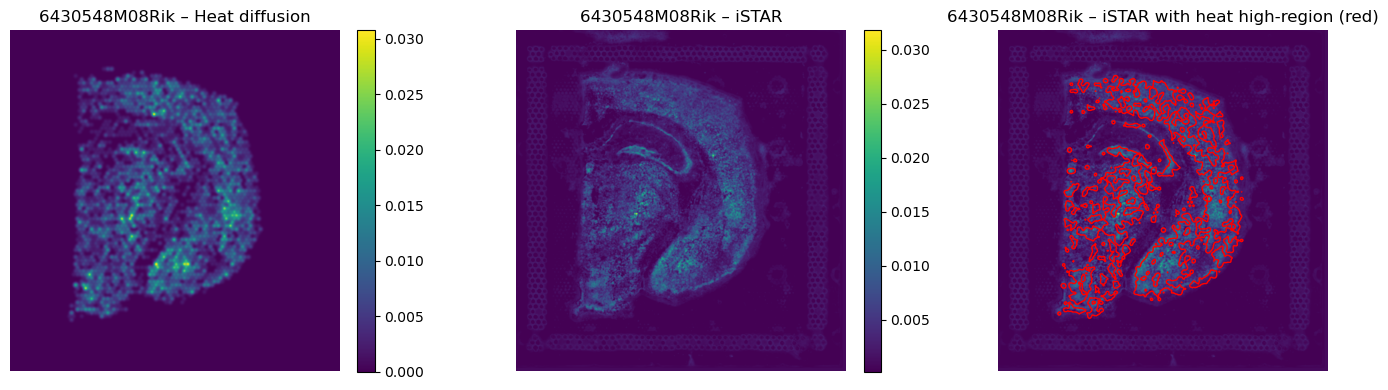

9230102O04Rik – skipped (iSTAR pickle not found)
9430038I01Rik – skipped (iSTAR pickle not found)
9430091E24Rik – skipped (iSTAR pickle not found)
9530082P21Rik – skipped (iSTAR pickle not found)
A230056P14Rik – skipped (iSTAR pickle not found)
A330074K22Rik – skipped (iSTAR pickle not found)
A430035B10Rik – skipped (iSTAR pickle not found)
A530058N18Rik – skipped (iSTAR pickle not found)
A930006K02Rik – skipped (iSTAR pickle not found)
A930009A15Rik – skipped (iSTAR pickle not found)
Aar2 – skipped (iSTAR pickle not found)
Aars2 – skipped (iSTAR pickle not found)
Aatf – skipped (iSTAR pickle not found)
Abca2 (912, 880)
Abca2 (912, 880)


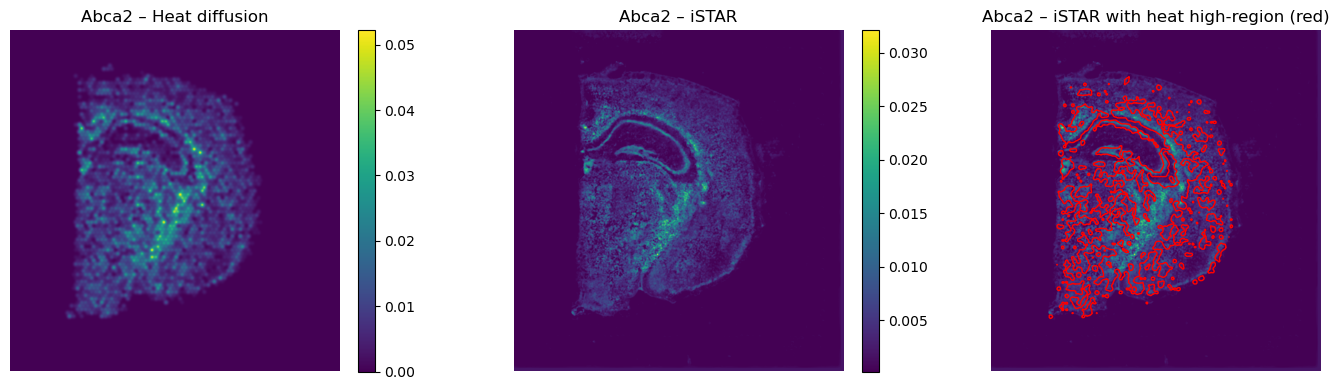

Abca3 – skipped (iSTAR pickle not found)
Abca9 – skipped (iSTAR pickle not found)
Abcb1a – skipped (iSTAR pickle not found)
Abcb7 – skipped (iSTAR pickle not found)
Abcc8 – skipped (iSTAR pickle not found)
Abcc9 – skipped (iSTAR pickle not found)
Abcd2 – skipped (iSTAR pickle not found)
Abcg2 – skipped (iSTAR pickle not found)
Abcg4 – skipped (iSTAR pickle not found)
Abhd2 (912, 880)
Abhd2 (912, 880)


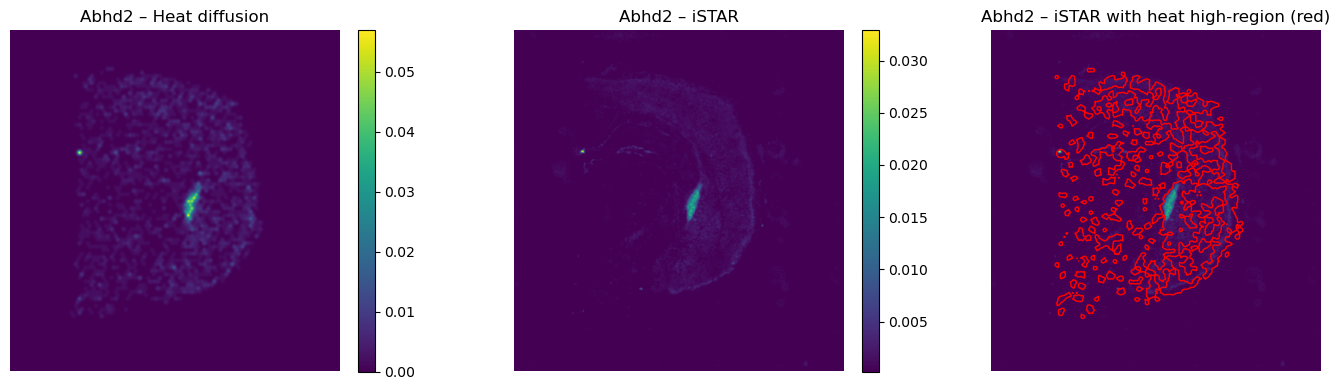

Abhd4 – skipped (iSTAR pickle not found)
Abi3 – skipped (iSTAR pickle not found)
Abt1 – skipped (iSTAR pickle not found)
Abtb2 – skipped (iSTAR pickle not found)
Acaa1a – skipped (iSTAR pickle not found)
Acadl – skipped (iSTAR pickle not found)
Acp1 (912, 880)
Acp1 (912, 880)


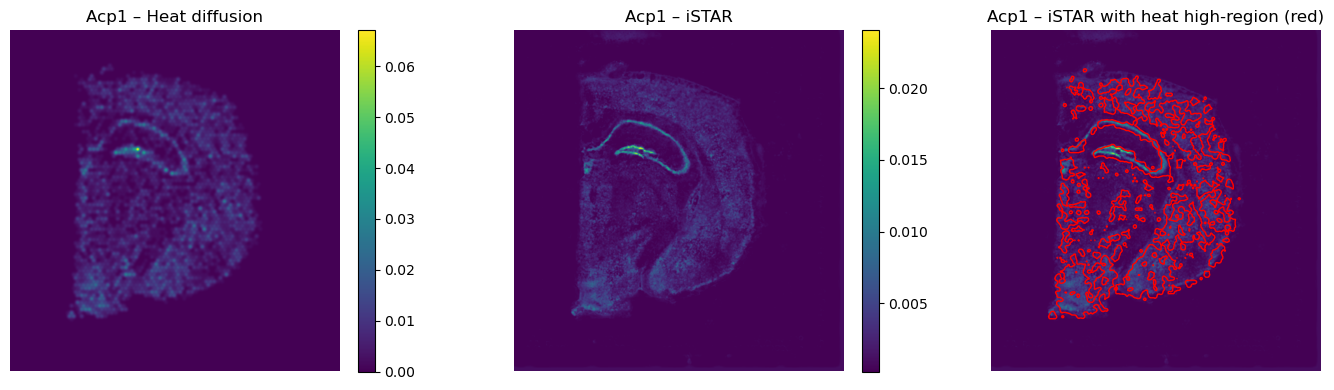

Acsl3 (912, 880)
Acsl3 (912, 880)


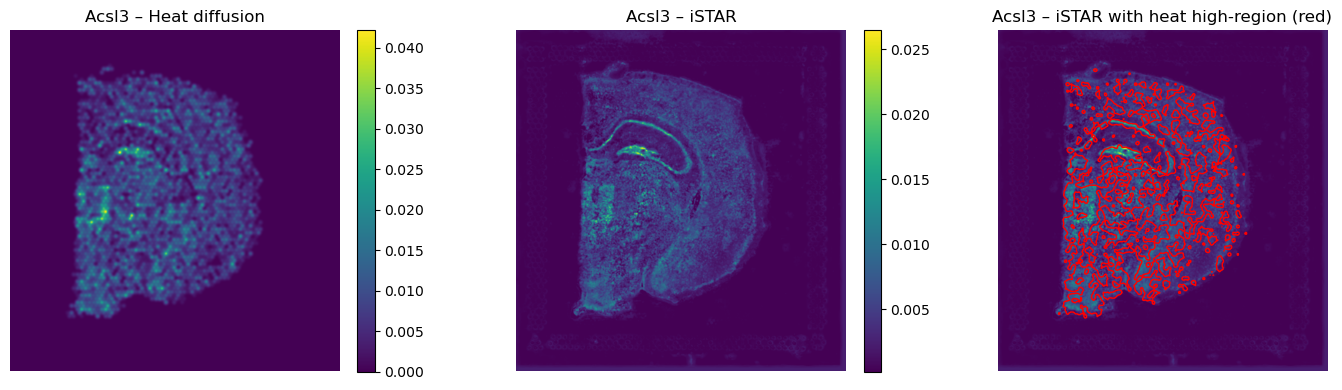

Acsl6 (912, 880)
Acsl6 (912, 880)


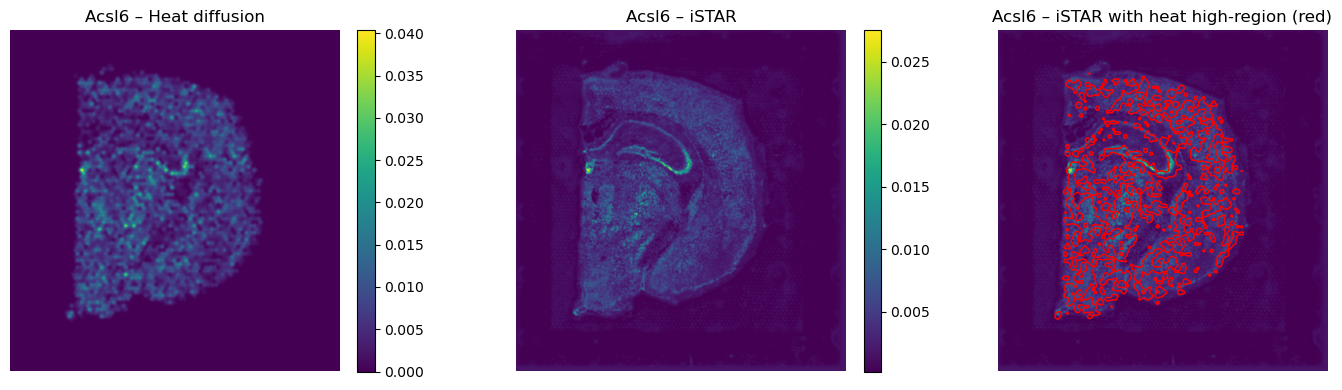

Acta2 (912, 880)
Acta2 (912, 880)


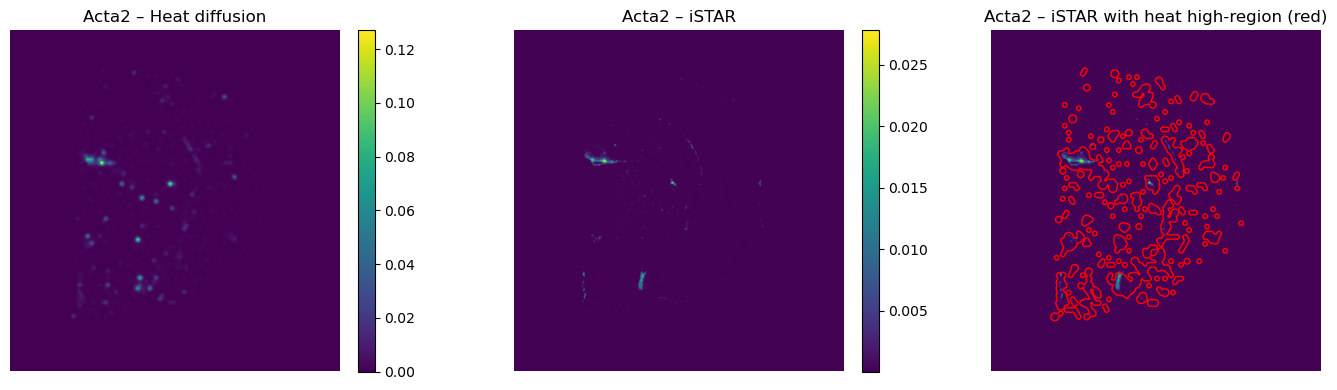

In [37]:
numgenes = 10

for g in genes_for_pixels:
    if numgenes == 0:
        break

    try:
        _ = load_istar_gene(g)   # just test load
    except FileNotFoundError:
        print(f"{g} – skipped (iSTAR pickle not found)")
        continue

    plot_with_contours(g)
    numgenes -= 1
